# Who is a Good Boy?
## An Abreviated intro to ResNet and Transfer Learning by Sam Bateman

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install scikit-image

In [5]:
import torchvision
from torchvision import transforms, utils
from skimage import io

In [6]:
from os.path import join

In [ ]:
!pip install kaggle

In [8]:
# Go to https://github.com/Kaggle/kaggle-api#api-credentials and follow instructions
!kaggle competitions download -c dog-breed-identification

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
from shutil import unpack_archive
unpack_archive('dog-breed-identification.zip', './dog-breed-identification/')

In [10]:
!ls

'DL Lecture Part 1.ipynb'   dog-breed-identification	   spiral_training.gif
'DL Lecture Part 2.ipynb'   dog-breed-identification.zip


In [11]:
import pandas as pd

In [12]:
labels_dataframe = pd.read_csv('dog-breed-identification/labels.csv')
labels_dataframe

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [13]:
labels_dataframe.iloc[0]['breed']

'boston_bull'

In [14]:
breed_labels = labels_dataframe.breed.unique()
breed_labels

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

In [15]:
len(breed_labels)

120

In [16]:
class DogBreedDataset(Dataset):
    def __init__(self, root_dir, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.transform = transform
        self.df = pd.read_csv(join(root_dir, 'labels.csv'))
        self.breed_labels = self.df.breed.unique()
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_name = str(self.df.iloc[idx]['id']) + '.jpg'
        img_name = join(join(self.root_dir, 'train/'), img_name)
        img = io.imread(img_name)
        
        breed = str(self.df.iloc[idx]['breed'])
        breed_idx = [i for i, el in enumerate(self.breed_labels) if el == breed][0]
        
        return self.transform(img), breed_idx
    def get_breed_from_idx(self, idx):
        return self.breed_labels[idx]

In [17]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])

In [18]:
train_dataset = DogBreedDataset('./dog-breed-identification/', train_transform)
val_dataset = DogBreedDataset('./dog-breed-identification/', val_transform)

In [19]:
train_dataset.get_breed_from_idx(train_dataset[100][1])

'rhodesian_ridgeback'

# Why Validation Set Matters

In [20]:
validation_split = 0.1
batch_size = 20

In [21]:
# create validation split
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

In [22]:
# shuffle dataset
random_seed = 104
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [23]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

In [24]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, num_workers=2, sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=2, sampler=val_sampler)

In [25]:
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

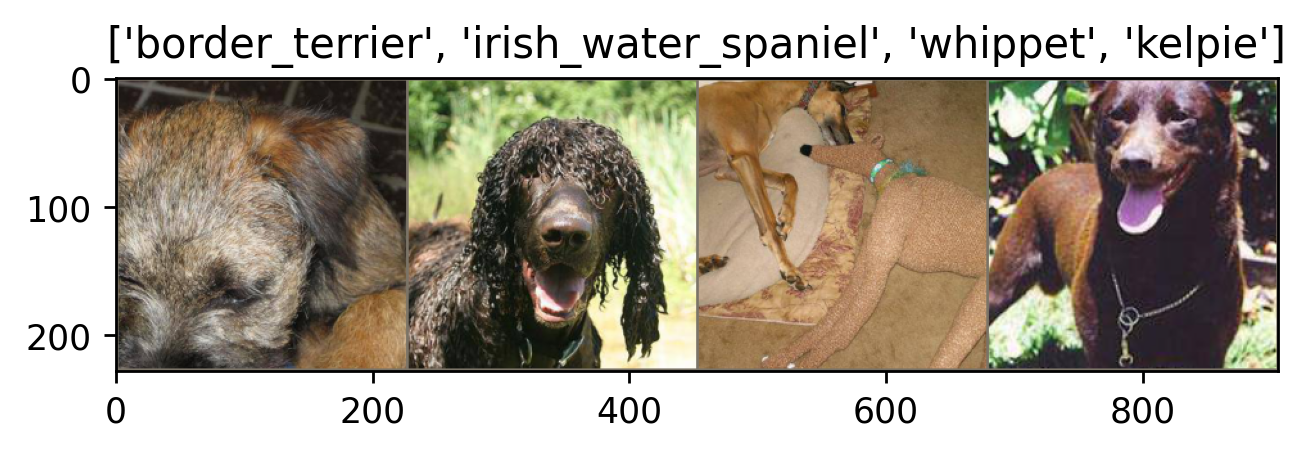

In [26]:
plt.figure(dpi=250)
inputs, classes = next(iter(val_dataloader))
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[val_dataset.breed_labels[x] for x in classes[:4]])

# Train from Scratch vs. Transfer Learning

In [27]:
len(train_dataloader)

460

In [28]:
from torchvision import models

In [29]:
pretrained_net = models.resnet18(pretrained=True)

In [30]:
for param in pretrained_net.parameters():
    param.requires_grad = False

In [31]:
pretrained_net.fc = nn.Linear(pretrained_net.fc.in_features, len(breed_labels))

In [32]:
net = pretrained_net.to(device)

In [33]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.fc.parameters(), lr=0.001, weight_decay=0.001)

In [34]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [35]:
epochs=10
print_freq = 100

In [36]:
net.train()
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    running_loss = 0.0
    for i, sample in enumerate(train_dataloader):
        img = sample[0].to(device)
        class_id = sample[1].to(device)
        optimizer.zero_grad()
        
        pred_class_id = net(img)
        
        loss = loss_function(pred_class_id, class_id)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if i % print_freq == print_freq - 1:
            print('[%d, %5d] Training Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (print_freq * batch_size)))
            running_loss = 0.0
    validation_loss = 0

    for i, sample in enumerate(val_dataloader):
        with torch.no_grad():
            img = sample[0].to(device)
            class_id = sample[1].to(device)
            optimizer.zero_grad()
            
            pred_class_id = net(img)
            
            loss = loss_function(pred_class_id, class_id)
            validation_loss += loss.item()
    scheduler.step(validation_loss/(len(val_dataloader)*batch_size))
        

    print('Epoch finished ! Validation Loss: {}'.format(validation_loss/(len(val_dataloader)*batch_size)))

Starting epoch 1/10.
[1,   100] Training Loss: 0.217
[1,   200] Training Loss: 0.155
[1,   300] Training Loss: 0.128
[1,   400] Training Loss: 0.111
Epoch finished ! Validation Loss: 0.08368068910562075
Starting epoch 2/10.
[2,   100] Training Loss: 0.093
[2,   200] Training Loss: 0.090
[2,   300] Training Loss: 0.086
[2,   400] Training Loss: 0.085
Epoch finished ! Validation Loss: 0.061705742088647986
Starting epoch 3/10.
[3,   100] Training Loss: 0.075
[3,   200] Training Loss: 0.077
[3,   300] Training Loss: 0.077
[3,   400] Training Loss: 0.076
Epoch finished ! Validation Loss: 0.05888267921713682
Starting epoch 4/10.
[4,   100] Training Loss: 0.071
[4,   200] Training Loss: 0.071
[4,   300] Training Loss: 0.070
[4,   400] Training Loss: 0.073
Epoch finished ! Validation Loss: 0.05429469547592677
Starting epoch 5/10.
[5,   100] Training Loss: 0.067
[5,   200] Training Loss: 0.069
[5,   300] Training Loss: 0.066
[5,   400] Training Loss: 0.066
Epoch finished ! Validation Loss: 0.05

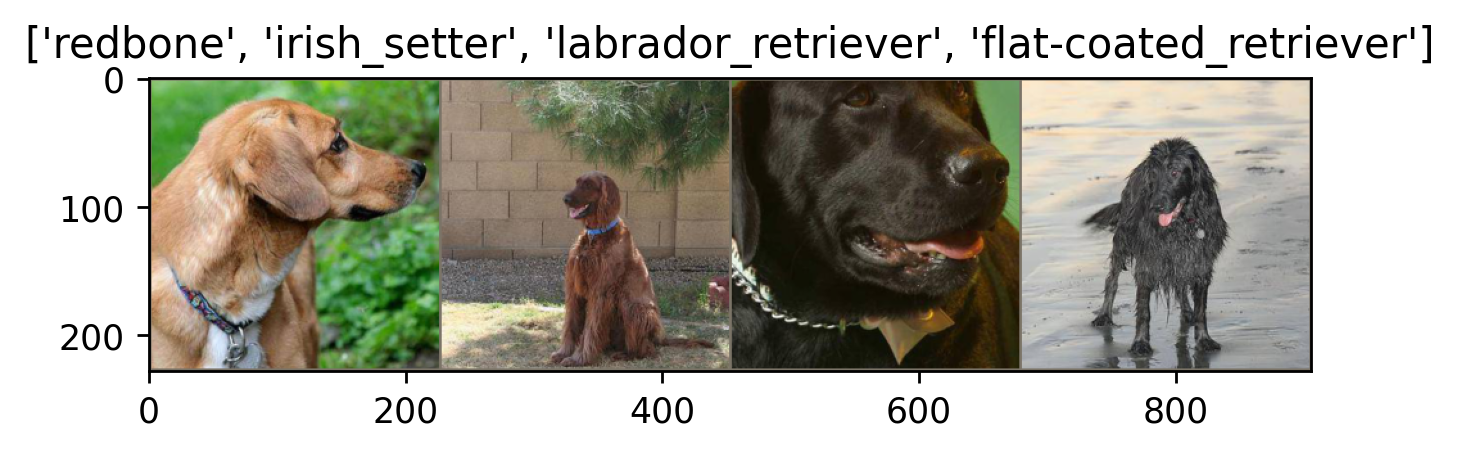

In [43]:
plt.figure(dpi=250)
inputs, classes = next(iter(val_dataloader))
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[val_dataset.breed_labels[x] for x in classes[:4]])

In [44]:
net.eval()
_, preds = torch.max(net(inputs.to(device)), 1) 
[val_dataset.breed_labels[i] for i in preds[:4]]

['redbone', 'irish_setter', 'labrador_retriever', 'scottish_deerhound']